In [1]:
import torch
import sys
import os
import cv2
import albumentations as A
import torch.nn.functional as F
import numpy as np 
from PIL import Image
import json
from pytorch_grad_cam.utils.image import show_cam_on_image
if "/opt/ml/level2_cv_semanticsegmentation-cv-09" not in sys.path:
    sys.path.append(os.path.join("/opt/ml/level2_cv_semanticsegmentation-cv-09"))

In [2]:
model_path = "/opt/ml/level2_cv_semanticsegmentation-cv-09/checkpoint/hrnet_ocr_best.pt"
image_path = "/opt/ml/train/DCM/ID001/image1661130828152_R.png"
json_path = "/opt/ml/train/outputs_json/ID001/image1661130828152_R.json"

In [3]:
CLASSES = [
        'finger-1', 'finger-2', 'finger-3', 'finger-4', 'finger-5',
        'finger-6', 'finger-7', 'finger-8', 'finger-9', 'finger-10',
        'finger-11', 'finger-12', 'finger-13', 'finger-14', 'finger-15',
        'finger-16', 'finger-17', 'finger-18', 'finger-19', 'Trapezium',
        'Trapezoid', 'Capitate', 'Hamate', 'Scaphoid', 'Lunate',
        'Triquetrum', 'Pisiform', 'Radius', 'Ulna',
        ]
PALETE = [
            (220, 20, 60), (119, 11, 32), (0, 0, 142), (0, 0, 230), (106, 0, 228),
            (0, 60, 100), (0, 80, 100), (0, 0, 70), (0, 0, 192), (250, 170, 30),
            (100, 170, 30), (220, 220, 0), (175, 116, 175), (250, 0, 30), (165, 42, 42),
            (255, 77, 255), (0, 226, 252), (182, 182, 255), (0, 82, 0), (120, 166, 157),
            (110, 76, 0), (174, 57, 255), (199, 100, 0), (72, 0, 118), (255, 179, 240),
            (0, 125, 92), (209, 0, 151), (188, 208, 182), (0, 220, 176),
        ]

CLASS2IND = {v: i for i, v in enumerate(CLASSES)}
IND2CLASS = {v: k for k, v in CLASS2IND.items()}

In [16]:
model = torch.load(model_path,map_location='cpu')
model.eval()

img = cv2.imread(image_path)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
rgb_img = img.copy()
with open(json_path,"r") as f:
    annotations = json.load(f)
annotations = annotations['annotations']
label = np.zeros((img.shape[0],img.shape[1],len(CLASSES)),dtype=np.uint8)

for ann in annotations:
    c = ann["label"]
    class_ind = CLASS2IND[c]
    points = np.array(ann["points"])
    
    # polygon to mask
    class_label = np.zeros(img.shape[:2], dtype=np.uint8)
    cv2.fillPoly(class_label, [points], 1)
    label[..., class_ind] = class_label

print(f"img_shape {img.shape}")
print(f"label_shape {label.shape}")
            

255
img_shape (2048, 2048, 3)
label_shape (2048, 2048, 29)


In [17]:
img = img/255.
result = A.Resize(1024,1024)(image=img,mask=label)
img = result['image']
label = result['mask']
rgb_img = np.float32(img)
img = img.transpose(2,0,1)
label = label.transpose(2,0,1)
img = torch.from_numpy(img).float().unsqueeze(0)
label = torch.from_numpy(label).float().unsqueeze(0)
print(f"img_shape {img.shape}")
print(f"label_shape {label.shape}")

255
img_shape torch.Size([1, 3, 1024, 1024])
label_shape torch.Size([1, 29, 1024, 1024])


In [6]:
output = model(img)
output = F.interpolate(output, size= img.shape[-2:], mode='bilinear')
print(output.shape)

torch.Size([1, 29, 1024, 1024])


In [7]:
loss = F.binary_cross_entropy_with_logits(output,label,reduction='none')
print(loss.shape)

torch.Size([1, 29, 1024, 1024])


In [8]:
slect_id = 21

In [19]:
result = torch.mean(loss,dim=[0])
result = (result - result.min())/result.max()
result = result[slect_id].detach().cpu().numpy()
print(result.shape)
print(result.max())

(1024, 1024)
0.68804413


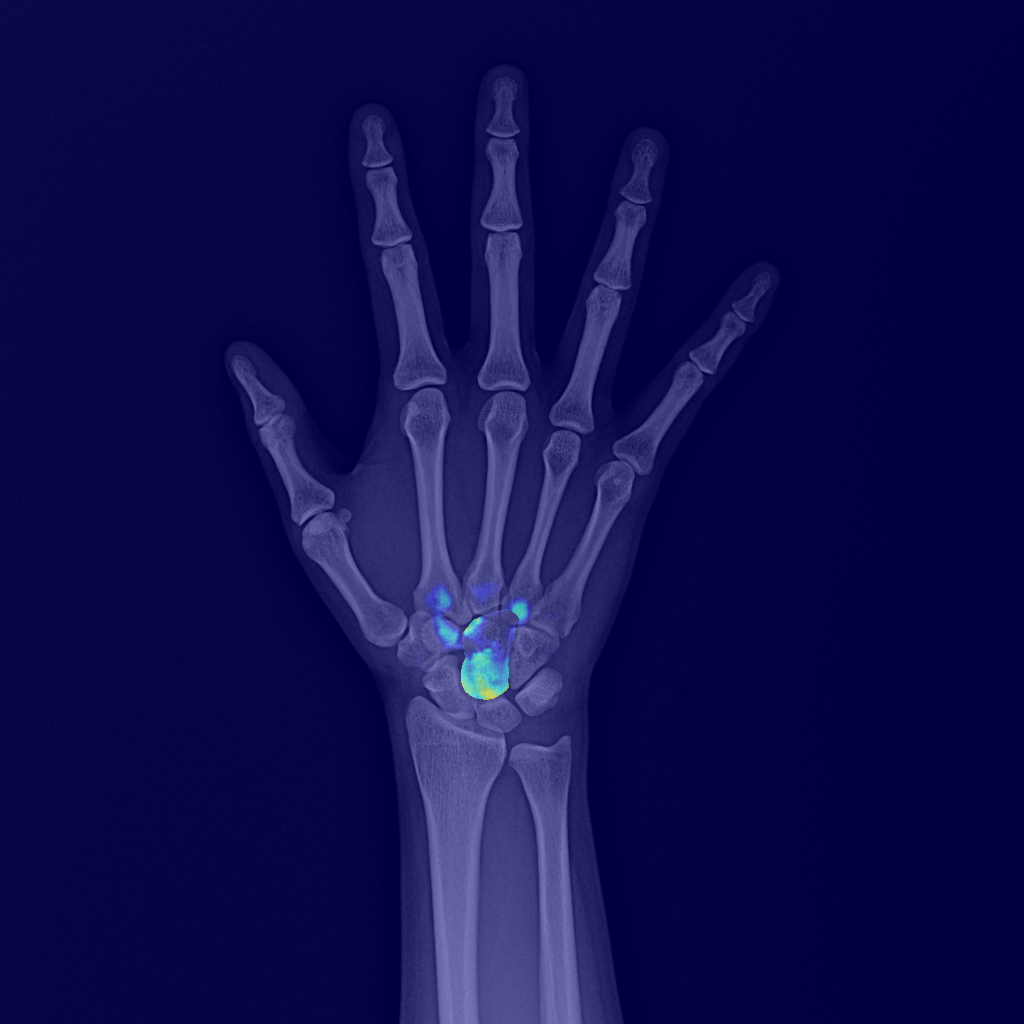

In [20]:
lossmap = cv2.applyColorMap(np.uint8(255 *result), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(lossmap,cv2.COLOR_BGR2RGB)
mix_loss = np.uint8(0.5 *rgb_img*255 + 0.5*heatmap)
Image.fromarray(mix_loss)

In [11]:
def label2rgb(label):
    image_size = label.shape[1:] + (3, )
    image = np.zeros(image_size, dtype=np.uint8)
    
    for i, class_label in enumerate(label):
        image[class_label == 1] = PALETE[i]
        
    return image

(1024, 1024, 3) (1024, 1024, 3) 0.97843134


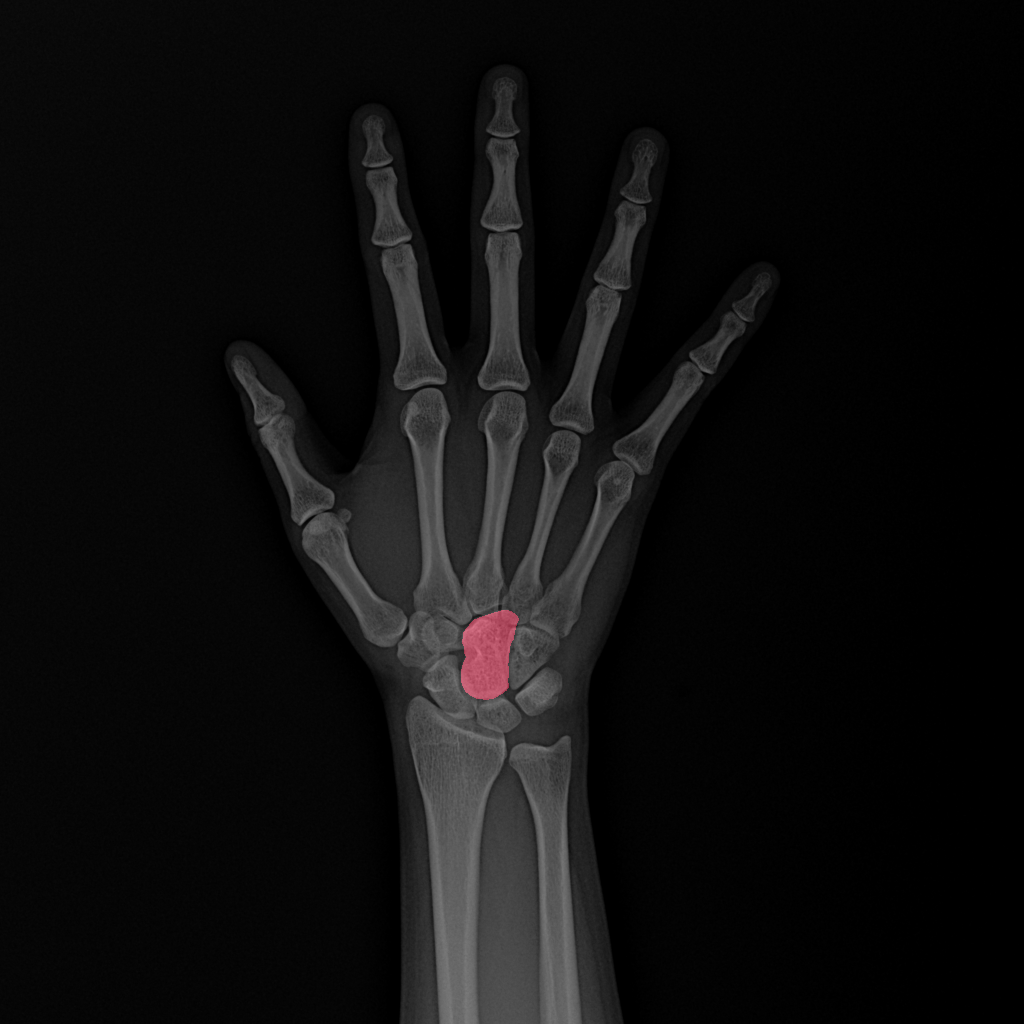

In [15]:
gt = label[0][slect_id]

gt_img= label2rgb(gt.unsqueeze(0))
print(gt_img.shape, rgb_img.shape, np.max(rgb_img))
mix_gt = np.uint8(0.5 *rgb_img*255 + 0.5*gt_img)
Image.fromarray(mix_gt)